# 3. CKY parsing

## Preparation

In [1]:
import matplotlib.pyplot as plt
import nltk

import time
from collections import defaultdict

from dataset import load_sentences, load_grammar
from parser import CkyParser
from measure import tree_f1_score


if False:   # Set this as True if it is your first time use NLTK grammer
    nltk.download("large_grammars")

In [2]:
# Grammar and corpus loading
grammar = load_grammar()
sentences = load_sentences()
parser = CkyParser(grammar)
print("Number of sentences:", len(sentences))
print(grammar)

Number of sentences: 98
Grammar with 16310 productions (start state = SIGMA)
    __NREL_VB__NP_NNS__VERB_HV__VERB_VB__ -> __NREL_VB__NP_NNS__VERB_HV__ VERB_VB
    NP_NNS -> __NP_NNS__QUANP_ABN__NP_NPS__NOUN_NNS__ PP_NP
    NOUN_NP -> 'july'
    LABEL_CD -> __NOUN_CD__seven__fifty__ seven
    SIGMA -> __DECL_VBG__VERB_VBG__PREP_IN__ pt_char_per
    IMPR_VB -> __IMPR_VB__VERB_VB__NP_PPO__NP_NNS__PP_NNS__PP_NP__PP_NP__PP_NP__ pt_char_per
    SIGMA -> f f
    __DECL_VB__NP_NNS__VERB_MD__VERB_VB__PREP_IN__ -> __DECL_VB__NP_NNS__VERB_MD__VERB_VB__ PREP_IN
    __PP_NNS__PREP_IN__QUANP_CD__NOUN_NNS__ -> __PP_NNS__PREP_IN__QUANP_CD__ NOUN_NNS
    __VP_VBZ__VERB_VBZ__PP_NP__ -> VERB_VBZ PP_NP
    NP_NN -> 'name'
    SIGMA -> 'wednesdays'
    AJP_JJ -> ADJ_JJ COMPCL_VB
    PP_VBZ -> __PP_VBZ__PREP_IN__NP_NN__VERB_VBZ__PP_NP__ PP_NP
    DECL_VBG -> __DECL_VBG__VERB_VBG__AVP_RB__ pt_char_per
    NOUN_NP -> 'connecticut'
    NP_NN -> __NP_NN__AJP_JJT__NOUN_NN__AJP_JJ__ pt_char_per
    AVPNP_NN -> 'j

In [3]:
if True:   # Set it as True to calculate the ground truth counts on the fly.
    nltk_parser = nltk.parse.BottomUpChartParser(grammar)
    gt_counts = [0] * len(sentences)
    for idx, senten in enumerate(sentences):
        try:
            chart = nltk_parser.chart_parse(senten)
        except ValueError:  # The parser will raise an ValueError with unknown words.
            continue
        gt_trees = list(chart.parses(grammar.start()))
        gt_counts[idx] = len(gt_trees)

    if False:   # Set it as True to save the ground truth counts into file.
        with open("../datasets/ground_truth_trees_counts.txt", "w", encoding="utf-8") as file:
            file.write("\n".join(map(str, gt_counts)))
else:
    with open("../datasets/ground_truth_trees_counts.txt", encoding="utf-8") as file:
        gt_counts = list(map(lambda x: int(x.strip()), file.readlines()))
    assert len(gt_counts) == len(sentences)

## Recognizer / Counter

Counter design: the core idea is, we record the counting on subtrees. When induce to the parent, the counting of the parent increases with the production of countings of children.

```
Data structure:
    Ch(i,k) eventually contains {A | A ⇒* wi ... wk-1}, initially all empty. 
    Counting(i,j,s) represents the number of parse trees of subsentence [i...j] with nonterminal s, initially all 0.

for each i from 1 to n:
    for each production rule A → w_i:
        add A to Ch(i, i+1)
        Counting(i,i+1,A) = 1

for each width b from 2 to n:
    for each start position i from 1 to n-b+1:
        for each left width k from 1 to b-1:
            for each B in Ch(i,i+k) and C in Ch(i+k,i+b):
                for each production rule A -> B C:
                    add A to Ch(i, i+b)
                    Counting(i,i+b,A) += Counting(i,i+k,B) * Counting(i+k,i+b,C)

Output: Counting(1,n,sigma)
```

In [4]:
grammatical_sentences = [
    "Hello .",
    "i am a flight .",
    "i am not a city .",
]
ungrammatical_sentences = [
    "I am ChatGPT .",
    "flight am a i .",
    "42",
    "Tatakai .",
    "Viva la Vida .",
]

# Test grammatical sentences
for senten in grammatical_sentences:
    assert parser.recognize(senten.lower().split())
    print(senten, "is grammatical")

# Test ungrammatical sentences. It's notable that number and some words are unable to be recognized.
for senten in ungrammatical_sentences:
    assert not parser.recognize(senten.lower().split())
    print(senten, "is ungrammatical")

Hello . is grammatical
i am a flight . is grammatical
i am not a city . is grammatical
I am ChatGPT . is ungrammatical
flight am a i . is ungrammatical
42 is ungrammatical
Tatakai . is ungrammatical
Viva la Vida . is ungrammatical


In [5]:
# Check my parse tree counts against the counts in NLTK, and print my parsing results
result_lines = list()
for senten, gt_cnt in zip(sentences, gt_counts):
    assert parser.count(senten) == gt_cnt
    result_lines.append(f"{' '.join(senten)}\t#{gt_cnt}")
    print(result_lines[-1])
if True:
    with open("parsing_results.txt", "w", encoding="utf-8") as file:
        file.write("\n".join(result_lines))

i need a flight from charlotte to las vegas that makes a stop in saint louis .	#2085
what is the cheapest one way flight from phoenix to san diego that arrives in the morning on thursday june second .	#1380
what is the cheapest one way flight from columbus to indianapolis .	#50
is there a flight from memphis to los angeles .	#18
what aircraft is this .	#0
please show me the flights from chicago to detroit that arrive at six p.m. next tuesday .	#20
what flights are available between chicago and indianapolis next wednesday between eleven a.m. and one p.m .	#0
please book a one way coach fare from chicago to indianapolis on united flight two ninety two next wednesday .	#0
show me flights from chicago to kansas city leaving around seven p.m. thursday .	#1059
show american flights after twelve p.m. from miami to chicago .	#0
does united flight four seven four slash fourteen eighty four serve dinner .	#0
what kind of aircraft is american 's flight fifteen oh one that departs at six fifty nin

## Parser

In [6]:
# Test the correctness
for senten, gt_cnt in zip(sentences, gt_counts):
    assert len(parser.parse(senten)) == gt_cnt

In [7]:
# Draw all the trees of a sentence with 4 parses
senten = sentences[-9]
trees = parser.parse(senten)
print(f"{' '.join(senten)}\t#{len(trees)}")

what are the costs .	#4


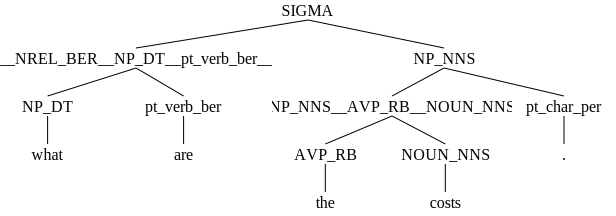

In [8]:
trees[0]

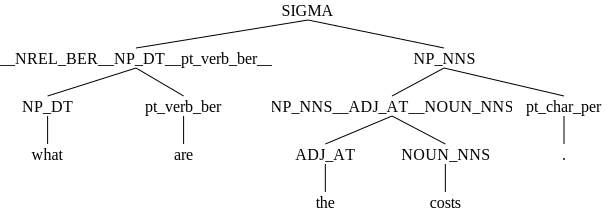

In [9]:
trees[1]

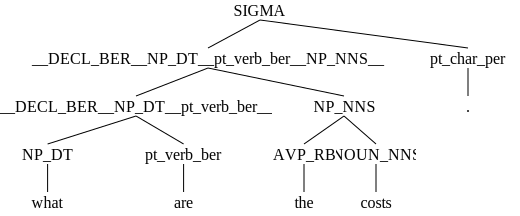

In [10]:
trees[2]

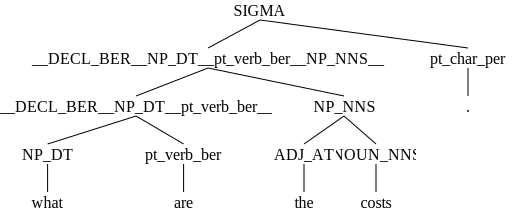

In [11]:
trees[3]

# Extra Points

## Sentence Length vs. Time

In [12]:
def timer(method, senten: list[str], gt_cnt: int) -> float:
    t = time.time()
    cnt = method(senten)
    t = time.time() - t
    if not isinstance(cnt, int):
        cnt = len(cnt)
    assert cnt == gt_cnt
    return t * 1000

sentence_counts = defaultdict[int, int](lambda: 0)
trees_counts = defaultdict[int, int](lambda: 0)
counting_times = defaultdict[int, float](lambda: 0.0)
parsing_times = defaultdict[int, float](lambda: 0.0)
for senten, gt_cnt in zip(sentences, gt_counts):
    length = len(senten)
    sentence_counts[length] += 1
    trees_counts[length] += gt_cnt
    counting_times[length] += timer(parser.count, senten, gt_cnt)
    parsing_times[length] += timer(parser.parse, senten, gt_cnt)

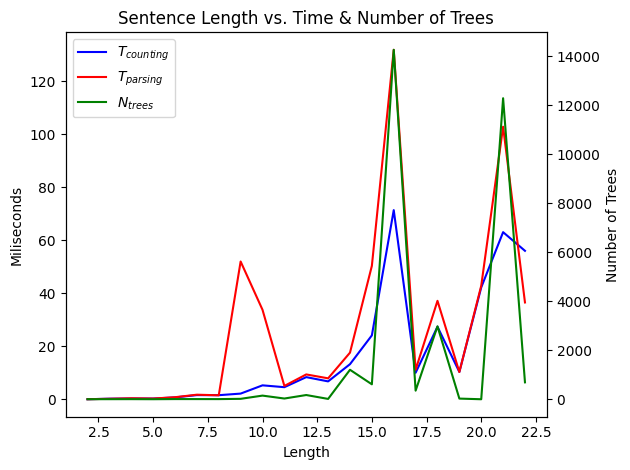

In [13]:
length = sorted(sentence_counts.keys())
ms_counting = [counting_times[k] / sentence_counts[k] for k in length]
ms_parsing = [parsing_times[k] / sentence_counts[k] for k in length]
num_trees = [trees_counts[k] / sentence_counts[k] for k in length]

line_a, = plt.plot(length, ms_counting, label="$T_{counting}$", c="b")
line_b, = plt.plot(length, ms_parsing, label="$T_{parsing}$", c="r")
plt.xlabel("Length") ; plt.ylabel("Miliseconds")

plt.twinx() ; plt.ylabel("Number of Trees")
line_c, = plt.plot(length, num_trees, label="$N_{trees}$", c="g")
plt.legend([line_a, line_b, line_c], [line_a.get_label(), line_b.get_label(), line_c.get_label()], loc="upper left")

plt.title("Sentence Length vs. Time & Number of Trees")
plt.tight_layout()
plt.show()

Analysis: We can see that,
- In most cases, $T_{counting} < T_{parsing}$. Because `count()` methods perform CKY algorithm and calculate the number of trees without compute all the parse trees, the time is saved. When the results contain a large number of parse trees, the gaps of time are more distinguishable
- Generally, the longer the sentence, the more computation time is required.

However, the time cost for some data points is unusually high. We can see that these data points are accompanied by a very large number of parse trees ($N_{trees}>10000$). This is caused by the inner loop of CKY algorithm:

```
for each B in Ch(i,i+k) and C in Ch(i+k,i+b):   # The scale increases with the number of trees
    for each production rule A -> B C:          # This is O(1) thanks to hash map (dict)
        add A to Ch(i, i+b)
```

## Labeled / Unlabeled Tree F1 Score

In [14]:
tree_a = parser.parse("i am a flight .".split())[0]
tree_b = parser.parse("i need a flight .".split())[0]

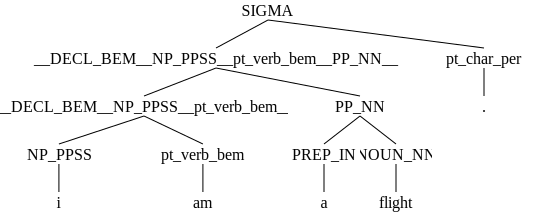

In [15]:
tree_a

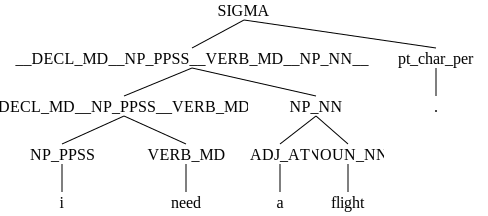

In [16]:
tree_b

In [17]:
print(tree_f1_score(tree_a, tree_b, unlabeled=False))
print(tree_f1_score(tree_a, tree_b, unlabeled=True))

0.4444444444444444
1.0


## PCFG Building

In [18]:
# Counting the rules on the trees
terminal_counts = defaultdict[tuple[str, str], int](lambda: 0)          # (T <- NT) => count
nonterminal_counts = defaultdict[tuple[str, str, str], int](lambda: 0)  # (L R <- P) => count
left_hand_counts = defaultdict[str, int](lambda: 0)                     # NT | P => count

def traverse(tree: nltk.Tree) -> None:
    assert 1 <= len(tree) <= 2
    parent: str = tree.label()
    left_hand_counts[parent] += 1
    if len(tree) == 1:  # leaf aka terminal
        child = tree[0]
        assert isinstance(child, str)
        terminal_counts[(child, parent)] += 1
        return
    left, right = tree
    assert isinstance(left, nltk.Tree) and isinstance(right, nltk.Tree)
    nonterminal_counts[(left.label(), right.label(), parent)] += 1
    traverse(left)
    traverse(right)

# Use the standard CKY Parser to produce all possible trees.
trees = sum([parser.parse(senten) for senten in sentences], [])
for t in trees: traverse(t)

# Build PCFG
terminal_probs = {k: v / left_hand_counts[k[-1]] for k, v in terminal_counts.items()}
nonterminal_probs = {k: v / left_hand_counts[k[-1]] for k, v in nonterminal_counts.items()}
productions = [
    nltk.ProbabilisticProduction(nltk.Nonterminal(k[-1]), [k[-2]], prob=v)
    for k, v in terminal_probs.items()
] + [
    nltk.ProbabilisticProduction(nltk.Nonterminal(k[-1]), (nltk.Nonterminal(kk) for kk in k[:-1]), prob=v)
    for k, v in nonterminal_probs.items()
]

pcfg = nltk.PCFG(grammar.start(), productions)
# assert pcfg.is_chomsky_normal_form()  # it's not CKF, because it does not contain the whole CFG. But it's enough for given sentences.
print(pcfg)

Grammar with 1948 productions (start state = SIGMA)
    NP_PPSS -> 'i' [0.999936]
    VERB_MD -> 'need' [0.222298]
    NOUN_NP -> 'a' [0.034373]
    NOUN_NN -> 'flight' [0.0368262]
    PREP_IN -> 'from' [0.335091]
    NOUN_NP -> 'charlotte' [0.00874029]
    PREP_IN -> 'to' [0.281971]
    las -> 'las' [1.0]
    vegas -> 'vegas' [1.0]
    NP_WPS -> 'that' [0.997166]
    VERB_VBZ -> 'makes' [0.561692]
    ADJ_AT -> 'a' [0.356738]
    NOUN_NN -> 'stop' [0.00794938]
    PREP_IN -> 'in' [0.145356]
    saint -> 'saint' [1.0]
    louis -> 'louis' [1.0]
    pt_char_per -> '.' [1.0]
    NP_NP -> 'a' [0.0368162]
    PREP_IN -> 'a' [0.0501992]
    NOUN_NP -> 'saint' [0.075918]
    NOUN_NP -> 'louis' [0.00335725]
    NP_NP -> 'saint' [0.0379936]
    AVPNP_NP -> 'louis' [0.0668989]
    NAPPOS_NP -> 'louis' [0.0322045]
    VERB_VB -> 'saint' [0.0786253]
    INFCL_VB -> 'stop' [0.00318314]
    AVP_RB -> 'to' [0.534586]
    AVPNP_NN -> 'stop' [0.000451824]
    INFCL_VB -> 'flight' [0.0114442]
    VERB_

## Viterbi CKY

In [19]:
pcfg_parser = nltk.parse.ViterbiParser(pcfg)
for idx, senten in enumerate(sentences):
    tree = parser.viterbi(senten, terminal_probs, nonterminal_probs)
    try:
        gt_tree = list(pcfg_parser.parse(senten))
    except ValueError:
        gt_tree = []
    if tree is None or len(gt_tree) == 0:
        assert tree is None and len(gt_tree) == 0
        continue
    f1 = tree_f1_score(tree, gt_tree[0], unlabeled=False)
    assert f1 == 1.0, f1
    assert abs(tree.logprob() - gt_tree[0].logprob()) < 1e-7
print("Assertion test pass. All tge trees generated by my ViterbiCKY are same as nltk.ViterbiParser")

Assertion test pass. All tge trees generated by my ViterbiCKY are same as nltk.ViterbiParser
